In [1]:
import math
import numpy as np
from graphviz import Digraph
from activation_functions import activations as act
global exp

In [2]:
exp = math.e

In [3]:
#GraphViz functionality
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [4]:
class Value():
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        out = Value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        out = Value(self.data + (-other.data),(self,other),'-')
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self,other):
        out = Value(self.data**other,(self,), f'**{other}')
        return out
    
    def tanh(self):
        #e^2x -1/e^2x + 1
        top = exp**(2*self.data) - 1
        bot = exp**(2*self.data) + 1
        tanh = top/bot
        out = Value(tanh,(self,),'tanh')
        
        def _backward():
            self.grad += (1-tanh**2) * out.grad
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
            
        def _backward():
            self.grad += (out.grad > 0) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

### The basic neural network can be represented as
## $$ \hat{y} = \sum(w_i.x_i) + bias$$
#### Where
#### x is the input feature
#### w is the respective weight for the input feature
#### b is the added bias
#### tanh is the activation function to add non linearity

In [5]:
x1 = Value(2.0,label='x1')
x2 = Value(3.0,label='x2')
w1 = Value(10.0,label='w1')
w2 = Value(-9.1999999999,label='w2')
b = Value(6.881313,label='b')

In [6]:
w1x1 = w1 * x1
w1x1.label = 'w1*x1'

In [7]:
w2x2 = w2 * x2
w2x2.label = 'w2*x2'

In [8]:
wsum = w1x1 + w2x2
wsum.label = 'sum'

In [9]:
pre = wsum + b
pre.label = 'bias'

In [11]:
y_hat = pre.tanh()
y_hat.label = 'yhat'

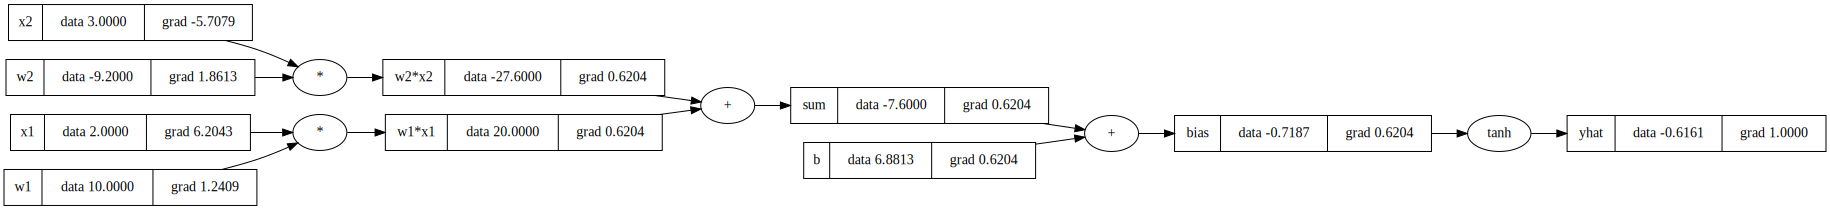

In [14]:
draw_dot(y_hat)

In [13]:
y_hat.backward()